# Final Notebook - Summary

This is the notebook that trains the final model on the cleaned dataset and produces a final prediction on the test data.

**Input to this notebook:** `final_cleaned_data.csv` (which is the output of notebook named `1_Data_Cleaning_Feature_Creation.ipynb`)


**In order to get the predictions:**
    
    Step 1: Run all cells from section 1 to 5.2.1 (Predictions)
    Step 2: Enter file name of test file in section 5.2.1.1
    Step 3: Run 5.2.2 to get predicted brands and accuracy

# Importing Libraries

In [1]:
import pandas as pd
import nltk
from nltk.stem.porter import PorterStemmer
import pandas as pd
import sys
import re
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import string
from nltk.corpus import stopwords
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import seaborn as sns
from gensim.parsing.preprocessing import remove_stopwords
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import nltk
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

/Users/sneharaj/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sneharaj/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sneharaj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load the clean data

The file `final_cleaned_data.csv` has the description cleaned and the features added to it. This is the same file that will be output from `1_Data_Cleaning_Feature_Creation.ipynb` 

In [2]:
behold_prod = pd.read_csv('final_cleaned_data.csv')

# Final Model Data Preparation

We have chosen **Logistic Regression** as our final model.
It has comparable performance to LSTM models and easier to explain. This model takes significantly less time to run compared to LSTM models


For data preparation we need to:
- Perform Count Vectorization on the Lemmatized description column followed by SVD to reduce dimensionality
- One-hot Encode the features and apply PCA to reduce feature space
- Concatenate the two arrays. This will become our X
- Label encode the brands. This becomes our y

## Count Vectorization

In [3]:
behold_prod.fillna('Blank',inplace=True)

In [4]:
countvectorizer = CountVectorizer(stop_words="english", binary=True, min_df=0.001)
X_cv = countvectorizer.fit_transform(behold_prod['lemmatized_description'].astype(str))

In [5]:
X_cv.shape

(61355, 2724)

## SVD on CountVectorisation

Linear dimensionality reduction using Singular Value Decomposition(SVD) of the data projects it to a lower dimensional space. Principal Component Analysis (PCA) can't work on the sparse matrix coming from Count Vectorizer. So we use SVD to reduce the dimensionality of the count vectorization output. 




Text(0, 0.5, 'Cumulative Explained variance')

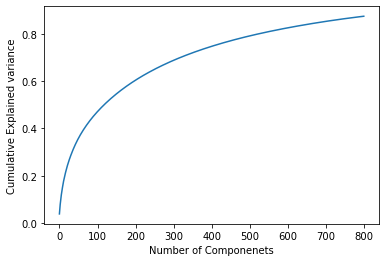

In [5]:
svd_cv = TruncatedSVD(n_components=800, n_iter=7, random_state=42)
svd_cv.fit(X_cv)
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.cumsum((svd_cv.explained_variance_ratio_)))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained variance")

In [85]:
# The top 600 components capture 80% variance
svd_cv=TruncatedSVD(n_components=600) 
princ_comps_cv=svd_cv.fit_transform(X_cv)

We keep the top 600 components which capture ~80% of the variance

## Feature Encoding

We use one-hot encoding for our categorical features.

In [86]:
enc=OneHotEncoder(handle_unknown='ignore')

for c in ['Made_In','final_fabric','Handcrafted','True_To_Size']:
    enc.fit(behold_prod[c].values.reshape(-1,1))
    FeatureInput=enc.transform(behold_prod[[c]]).toarray()
    if c=='Made_In':
        cat_feat_array=FeatureInput
    else:
        cat_feat_array=np.concatenate([FeatureInput,cat_feat_array],axis=1)

12
28
2
2


In [87]:
# There are different fields for washtype so we convert them into an array as well
washtype_df = behold_prod[['is_dry_clean', 'is_hand_wash', 'is_machine_wash_cold',
       'is_machine_wash', 'is_tumble_dry', 'is_not_bleach']]
washtype_array = washtype_df.to_numpy()

In [88]:
# Combining the two datasets to produce an array of the encoded features
cat_feat_array=np.concatenate([washtype_array,cat_feat_array],axis=1)

In [89]:
cat_feat_array.shape

(61355, 50)

## PCA on Encoded Features

Encoded features have length of 50. We would perform PCA to keep the ones which captures about >90% of the variance.

Text(0, 0.5, 'Cumulative Explained variance')

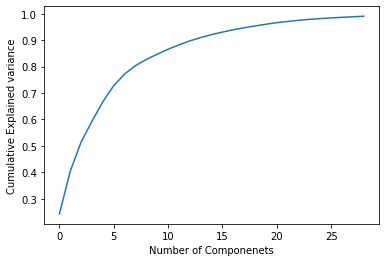

In [90]:
pca=PCA(n_components=0.99,svd_solver="full")
pca.fit(cat_feat_array)

plt.plot(np.cumsum((pca.explained_variance_ratio_)))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained variance")

In [91]:
pca=PCA(n_components=20) #  around 100% captured by 25 features
features_princ_comps=pca.fit_transform(cat_feat_array)

## Final Model

### Label encoding of Target variable

In this stage we are label encoding the 31 labels (top 30 brand names) to numerical values so that we can feed it as `y` to our Logistic Regression Model

In [92]:

le = preprocessing.LabelEncoder()
le.fit(behold_prod['label'].astype(str))
y=le.transform(behold_prod['label'].astype(str))

### Concatenation of Features

The reduced features (through PCA and SVD) from both Count Vectorization and Categorical features are concatenated to create our X.

In [97]:
 X_all=np.concatenate([princ_comps_cv,features_princ_comps],axis=1)

In [98]:
X_all.shape

(61355, 650)

### Train and Test

We split the data into training and testing datasets ensuring `stratify=y` to maintain a representative distribution of the labels.

In [99]:
lr=LogisticRegression(max_iter=500)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_all ,y, test_size=0.2, random_state=1,stratify=y)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# calculate accuracy ~around 87-88% across multiple train test split
print(np.mean(y_pred == y_test))

> We were getting around 90-91% accuracy on test data without using PCA/SVD on count vectoriser and encoded features. But chosen the PCA route to reduce dimensionality and correlation among features

## Further tuning the model to get best performance in unknown set

In [ ]:
# Fitting on whole data with same settings
lr.fit(X_all, y) 

In [ ]:
# y_pred = lr.predict(X_test)
# print(np.mean(y_pred == y_test))

# Function to get prediction from a test dataset

## Supporting Functions

We declare functions in this section so that we can process our input file the same way as the original data set.

### Stopwords

In [20]:
# declaring stopwords to add 
stopwords_mod = ['moreover', 'only', 'eight', 'otherwise', 'unless', 'done', 'as', 'somehow',
 'off', 'three', 'do', 'become', 'nothing', 'a', 'top', 'describe', 'not',
 'although', 'co', 'if', 'mostly', 'such', 'third', 'myself', 'sometime',
 'because', 'yours', 'within', 'noone', 'former', 'through', 'seeming',
 'further', 'fifteen', 'had', 'inc', 'into', 'is', 'who', 'amount', 'during', 'per', 'doing',
 'for', 'neither', 'an', 'yourself', 'under', 'still', 'doesn', 'this', 'name', 'rather', 'it',
 'whence', 'toward', 'various', 'somewhere', 'the', 'hasnt', 'few', 'thereupon', 'alone', 'all', 'own', 'yet',
 'well', 'ourselves', 'anywhere', 'with', 'many', 'themselves', 'until',
 'side', 'move', 'from', 'its', 'her', 'upon', 'here', 'don', 'above',
 'wherein', 'their', 'becomes', 'thus', 'up', 'either', 'another', 'can', 'beforehand', 'twelve', 'ours', 'call',
 'hereafter', 'me', 'part', 'less', 'between', 'other', 'de', 'kg', 'nowhere', 'at', 'without', 'among', 'thin', 'anyway', 'towards', 'using',
 'see', 'what', 'serious', 'whether', 'perhaps', 'thereafter', 'or', 'put', 'thick', 'sixty', 'five', 'i', 'how', 'even', 'one', 'didn', 'below', 'which', 'first', 'them', 'hundred', 'hereupon', 'mill', 'been', 'besides', 'to', 'amongst', 'make', 'however', 'just', 'must', 'both', 'each', 'any', 'again', 'are', 'everyone', 'herein', 'bill', 'then', 'get', 'fifty',
 'anyone', 'whereby', 'so', 'un', 'became', 'nor', 'were', 'used', 'whereupon',
 'show', 'give', 'seems', 'but', 'always', 'against', 'him', 'wherever', 'made',
 'some', 'last', 'along', 'computer', 'anyhow', 'cry', 'about', 'that', 'on', 'due',
 'meanwhile', 'his', 'our', 'when', 'these', 'and', 'several', 'formerly', 'since',
 'whole', 'am', 'eleven', 'once', 'whoever', 'eg', 'please', 'amoungst', 'least',
 'hence', 'us', 'ie', 'go', 'ever', 'every', 'none', 'others', 'of', 'fire', 'whenever', 'too', 'indeed',
 'already', 'by', 'becoming', 'whose', 'something', 'yourselves', 're', 'around', 'nine', 'via', 'where', 'forty', 'hereby', 'everything', 'sometimes', 'system', 'might', 'no', 'across', 'could', 'very', 'more', 'behind', 'afterwards', 'whereas', 'twenty', 'while', 'out', 'ten', 'latterly', 'namely', 'be', 'should', 'thereby', 'mine', 'whom', 'fill', 'two', 'beyond', 'take', 'my', 'else', 'throughout', 'would', 'thence', 'say', 'will', 'down', 'does', 'together', 'though', 'next', 'also', 'we', 'back', 'cannot', 'sincere', 'most', 'seemed', 'therein', 'she', 'being',
 'latter', 'they', 'seem', 'did', 'detail', 'whatever', 'someone', 'himself', 'regarding', 'nobody', 'six', 'bottom', 'elsewhere', 'find', 'etc', 'couldnt', 'your', 'interest', 'has', 'ltd', 'therefore', 'thru', 'four', 'km', 'anything', 'quite', 'now', 'everywhere', 'those', 'con', 'much', 'you', 'than', 'same', 'keep', 'full', 'cant', 'beside', 'herself', 'except', 'itself', 'after', 'may', 'before', 'often', 'in', 'almost', 'nevertheless', 'why', 'have', 'front', 'enough', 'whereafter', 'there', 'whither', 'he', 'found', 'really', 'hers', 'no','in',
 'empty', 'never', 'was', 'onto', 'over']

In [21]:
# Defining custom stopwords
custom_sw = ['size', 'fit','height', 'wide',
             'waist','bust' 'hip','measurement',
             'model','wear','small','medium','large',
            'sizing','high','small','long','cm','easy']
stopwords_list = stopwords_mod + custom_sw


In [22]:
# Function to remove stopwords
def remove_sw(text):
    ''' Remove Stopwords'''
    text = str(text)
    # split sentence into words
    words = word_tokenize(text)
    
    new_words = []
    # remove stopwords
    for w in words:
        if w in stopwords_list:
            continue
        new_words.append(w)
    return ' '.join(new_words)

In [23]:
def remove_whitespace(row):
    '''Function to remove the single white space in certain rows'''
    if len(row)==0:
        return 'Blank'
    else:
        return row

In [24]:
# remove other stopwords pattern
pattern=r'\b(mm|(x)?(x)?s|wear(s|ing)?|measurements?|x|new(est)?|detail(s|ed)?|)\b'


### Made In

In [25]:
def extract_madein(product): 
    ''' Extracting the location from 'details' and 'description' columns of the dataset passed'''
    location_list_clean = []
    for rows in range(0,len(product)):
        #check if content in description column, if not (aka null), there's usually content in details column
        if pd.isnull(product.loc[rows,'description']):
            if pd.isnull(product.loc[rows,'details']):
                location_list_clean.append('None')
                continue
            else:
                #append entity to list and operate on the details column, will be used to slap it onto main dataframe later
                if len(re.findall(r'\b(USA|United States)\b',str(product.loc[rows,'details']),flags=re.IGNORECASE)) >= 1:
                    location_list_clean.append('USA')
                elif len(re.findall(r'\b(Italy)\b',str(product.loc[rows,'details']),flags=re.IGNORECASE)) >= 1:
                    location_list_clean.append('Italy')
                elif len(re.findall(r'\b(New York|NewYork|new_york_city|NewYorkCity|NY|NYC|N\.Y\.)\b',str(product.loc[rows,'details']),flags=re.IGNORECASE)) >= 1:
                    location_list_clean.append('New York')
                elif len(re.findall(r'\b(Los Angeles|LA|LosAngeles|L\.A\.)\b',str(product.loc[rows,'details']),flags=re.IGNORECASE)) >= 1:
                    location_list_clean.append('LA')
                elif len(re.findall(r'\b(Ghana)\b',str(product.loc[rows,'details']),flags=re.IGNORECASE)) >= 1:
                    location_list_clean.append('Ghana')
                elif len(re.findall(r'\b(China)\b',str(product.loc[rows,'details']),flags=re.IGNORECASE)) >= 1:
                    location_list_clean.append('China')
                elif len(re.findall(r'\b(India)\b',str(product.loc[rows,'details']),flags=re.IGNORECASE)) >= 1:
                    location_list_clean.append('India')
                elif len(re.findall(r'\b(Spain)\b',str(product.loc[rows,'details']),flags=re.IGNORECASE)) >= 1:
                    location_list_clean.append('Spain')
                elif len(re.findall(r'\b(France)\b',str(product.loc[rows,'details']),flags=re.IGNORECASE)) >= 1:
                    location_list_clean.append('France')
                elif len(re.findall(r'\b(London|UK|U\.K\.)\b',str(product.loc[rows,'details']),flags=re.IGNORECASE)) >= 1:
                    location_list_clean.append('London/UK')
                elif len(re.findall(r'\b(Japan|Tokyo)\b',str(product.loc[rows,'details']),flags=re.IGNORECASE)) >= 1:
                    location_list_clean.append('Japan')
                else:
                    location_list_clean.append('None')
        else:
            #do the same thing as above if content is in description column
                if len(re.findall(r'\b(USA|United States)\b',str(product.loc[rows,'description']),flags=re.IGNORECASE)) >= 1:
                    location_list_clean.append('USA')
                elif len(re.findall(r'\b(Italy)\b',str(product.loc[rows,'description']),flags=re.IGNORECASE)) >= 1:
                    location_list_clean.append('Italy')
                elif len(re.findall(r'\b(New York|NewYork|new_york_city|NewYorkCity|NY|NYC|N\.Y\.)\b',str(product.loc[rows,'description']),flags=re.IGNORECASE)) >= 1:
                    location_list_clean.append('New York')
                elif len(re.findall(r'\b(Los Angeles|LA|LosAngeles|L\.A\.)\b',str(product.loc[rows,'description']),flags=re.IGNORECASE)) >= 1:
                    location_list_clean.append('LA')
                elif len(re.findall(r'\b(Ghana)\b',str(product.loc[rows,'description']),flags=re.IGNORECASE)) >= 1:
                    location_list_clean.append('Ghana')
                elif len(re.findall(r'\b(China)\b',str(product.loc[rows,'description']),flags=re.IGNORECASE)) >= 1:
                    location_list_clean.append('China')
                elif len(re.findall(r'\b(India)\b',str(product.loc[rows,'description']),flags=re.IGNORECASE)) >= 1:
                    location_list_clean.append('India')
                elif len(re.findall(r'\b(Spain)\b',str(product.loc[rows,'description']),flags=re.IGNORECASE)) >= 1:
                    location_list_clean.append('Spain')
                elif len(re.findall(r'\b(France)\b',str(product.loc[rows,'description']),flags=re.IGNORECASE)) >= 1:
                    location_list_clean.append('France')
                elif len(re.findall(r'\b(London|UK|U\.K\.)\b',str(product.loc[rows,'description']),flags=re.IGNORECASE)) >= 1:
                    location_list_clean.append('London/UK')
                elif len(re.findall(r'\b(Japan|Tokyo)\b',str(product.loc[rows,'description']),flags=re.IGNORECASE)) >= 1:
                    location_list_clean.append('Japan')
                else:
                    location_list_clean.append('None')
    return location_list_clean

### Handcraft

In [26]:
def extract_handcraft(df):
    ''' Extracting the Hand-crafted feature from 'details' and 'description' columns of the dataset passed'''
    handcrafted_list = []
    truetosize_list = []
    for rows in range(0,len(df)):
        #check if content in description column, if not (aka null), there's usually content in details column
        if pd.isnull(df.loc[rows,'description']):
            if pd.isnull(df.loc[rows,'details']):
                handcrafted_list.append(0)
                continue
            else:
                #append entity to list and operate on the details column, will be used to slap it onto main dataframe later
                if len(re.findall(r'\b(handcrafted|hand-crafted)\b',str(df.loc[rows,'details']),flags=re.IGNORECASE)) >=1:
                    handcrafted_list.append(1)
                else:
                    handcrafted_list.append(0)

        else:
            #do the same thing as above if content is in description column
                if len(re.findall(r'\b(handcrafted|hand-crafted)\b',str(df.loc[rows,'description']),flags=re.IGNORECASE)) >=1:
                    handcrafted_list.append(1)
                else:
                    handcrafted_list.append(0)

    return handcrafted_list

### True to Size

In [27]:
def extract_truetosize(df):
    ''' Extracting the whether the description mentions True to Size from 'details' and 'description' columns of the dataset passed'''
    truetosize_list = []
    for rows in range(0,len(product)):
        #check if content in description column, if not (aka null), there's usually content in details column
        if pd.isnull(product.loc[rows,'description']):
            if pd.isnull(product.loc[rows,'details']):
                truetosize_list.append(0)
                continue
            else:
                #append entity to list and operate on the details column, will be used to slap it onto main dataframe later
                if len(re.findall(r'\b(true to size)\b',str(product.loc[rows,'details']),flags=re.IGNORECASE)) >=1:
                    truetosize_list.append(1)
                else:
                    truetosize_list.append(0)

        else:
            #do the same thing as above if content is in description column
                if len(re.findall(r'\b(true to size)\b',str(product.loc[rows,'description']),flags=re.IGNORECASE)) >=1:
                    truetosize_list.append(1)
                else:
                    truetosize_list.append(0)
    return truetosize_list

### Wash Type

In [28]:
def findCare(txt):
    """ Function to determine the care method of item """
    txt = str(txt)
    val = []
    care_re = r'\b(dry clean|hand wash|not? bleach|tumble dry|hang dry\
                |machine wash cold|machine wash|(?:[don\'t|not?]) machine wash)\b'
    if re.findall(care_re, txt, re.IGNORECASE ):
        val = re.findall(care_re, txt, re.IGNORECASE)
    return val

In [29]:
def is_dry_clean(txt):
    '''Function to check for dry clean condition'''
    txt = str(txt)
    val = 0
    if re.search(r'\b(dry clean)\b', txt, re.IGNORECASE ):
        val = 1
   
    return val

In [30]:
def is_hand_wash(txt):
    '''Function to check for hand wash instructions'''
    txt = str(txt)
    val = 0
    if re.search(r'\b(handwash)\b', txt, re.IGNORECASE ):
        val = 1
   
    return val

In [31]:
def is_machine_wash_cold(txt):
    '''Function to check for machine wash cold instruction'''
    txt = str(txt)
    val = 0
    if re.search(r'\b(machine wash cold)\b', txt, re.IGNORECASE ):
        val = 1
   
    return val

In [32]:
def is_machine_wash(txt):
    '''Function to check for machine wash instruction'''
    txt = str(txt)
    val = 0
    if re.search(r'\b(machine wash)\b', txt, re.IGNORECASE ):
        val =1
   
    return val

In [33]:
def is_tumble_dry(txt):
    '''Function to check for tumble dry instructions'''
    txt = str(txt)
    val = 0
    if re.search(r'\b(tumble dry)\b', txt, re.IGNORECASE ):
        val = 1
   
    return val

In [34]:
def is_not_bleach(txt):
    '''Function to check for do not bleach instruction'''
    txt = str(txt)
    val = 0
    if re.search(r'\b((not|no) bleach)\b', txt, re.IGNORECASE ):
        val = 1
   
    return val


### Fabric

In [35]:
def findFabric(txt):
    """ Function to determine the fabric of item """
    fabric_re = r'\b(broadcloth|brocade|calico|cashmere|chambray|chiffon|corduroy|cotton|eyelet|faille|foulard|furbelow|fustian|gingham|grosgrain|jacquard|knit\
                    |linen|lisle|madras|merino|paisley|sateen|satin|\
                    seersucker|shetland|silk|taffeta|tulle|velvet|polyester|rayon)\b'
    val = []
    txt = str(txt)
    if re.findall(fabric_re, txt, re.IGNORECASE ):
        val = re.findall(fabric_re, txt, re.IGNORECASE )
    return val

### Lemmatization Function

In [36]:

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    
def lemmatize_sentence(sentence):
    sentence = str(sentence)
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return lemmatized_sentence


## Main Function

### Predictions

#### Read in the test data

Please enter the filename of the test dataset into `filename=` and run the subsequent cells.

In [38]:
# filename=<Please type in filename>
product = pd.read_excel('Behold+product+data+04262021.xlsx')


In [39]:
import warnings
warnings.filterwarnings("ignore")

def get_predictons(data):
    '''data: Test Data
    This function generates the array with predicted brands.
    This function requires the following columns in the test data:
    - description
    - details
    - name '''
    
    data.fillna('None',inplace = True)
    # remove less useful elements
    data.description = data.description.str.replace('\n',' ')
    data.description = data.description.str.replace('\r',' ')
    data.description = data.description.str.replace(r'  ',' ')
    data.description = data.description.str.replace(r'\bs\b','')
    # # remove punctuations
    data.description = data.description.str.replace(r'[^A-Za-z0-9 ]+','')
    data.description = data.description.str.lower()
    # Handcraft
    data['Handcrafted']=extract_handcraft(data)
     
    # Parsing out location
    
    data['description'] = data['description'].str.\
                                replace(r'\bnew\b\s\byork\b\s(?:\bcity\b)?','new_york_city ')

    data['description'] = data['description'].str.\
                                    replace(r'\b(?:the\s)?usa?\b','USA')
    data['description'] = data['description'].str.\
                                    replace(r'\b(?:the\s)?united\sstates\b','USA')
    # Made-in information extraction
    data['Made_In']=extract_madein(data)
    
    
    #Fabric parsing
    data['fabric_list'] = data['description'].apply(findFabric) +data['name'].apply(findFabric)              
    data['fabrics'] = data['fabric_list'].apply(lambda x: set(y.lower() for y in x))
    data['n_fabric'] = data['fabrics'].apply(len)
    data['final_fabric'] = np.nan
    data.loc[data['n_fabric']>1,'final_fabric'] = 'multi'
    data.loc[data['n_fabric']==1,'final_fabric'] = \
           data.loc[data['n_fabric']==1,'fabrics'].apply(lambda x:list(x)[0])
    # True to size
    data['True_To_Size']=extract_truetosize(data)
    # Wash Type
    data['care_list'] = data['description'].apply(findCare)              
    data['wash_type'] = data['care_list'].apply(lambda x: set(y.lower() for y in x))
    data['is_dry_clean'] = pd.DataFrame(data.description.apply(is_dry_clean))
    data['is_hand_wash'] = pd.DataFrame(data.description.apply(is_hand_wash))
    data['is_machine_wash'] = pd.DataFrame(data.description.apply(is_machine_wash))
    data['is_machine_wash_cold'] = pd.DataFrame(data.description.apply(is_machine_wash_cold))
    data['is_not_bleach'] = pd.DataFrame(data.description.apply(is_not_bleach))
    data['is_tumble_dry'] = pd.DataFrame(data.description.apply(is_tumble_dry))
   
    # Stopwords
    data['description'] = data['description'].apply(remove_sw)
    data.description=data.description.str.replace(pattern,'')
    data.description=data.description.apply(remove_whitespace)
    
      #Lemmatization
    lemmatized_descriptions = []
    for des in data['description']:
        lemmatized_description =  lemmatize_sentence(des)
        lemmatized_descriptions.append(lemmatized_description)
    lemmatized_description_join = []
    for doc in tqdm(lemmatized_descriptions):
        new_doc = ' '.join(doc)
        lemmatized_description_join.append(new_doc)

    data.fillna('Blank',inplace=True)
    data['lemmatized_description'] = lemmatized_description_join 
        
    #Count Vectorisation
    X_cv = countvectorizer.transform(data['lemmatized_description'].astype(str))
    
    #SVD on Count Vectorisation
    princ_comps_cv=svd_cv.transform(X_cv) 
    
    #Feature encoding
    for c in ['Made_In','final_fabric','Handcrafted','True_To_Size']:
        enc.fit(behold_prod[c].values.reshape(-1,1)) #fits on known data
        FeatureInput=enc.transform(data[[c]]).toarray() #transforms on test
        if c=='Made_In':
            cat_feat_array=FeatureInput
        else:
            cat_feat_array=np.concatenate([FeatureInput,cat_feat_array],axis=1)
    washtype_df = data[['is_dry_clean', 'is_hand_wash', 'is_machine_wash_cold',
           'is_machine_wash', 'is_tumble_dry', 'is_not_bleach']]
    washtype_array = washtype_df.to_numpy()
    cat_feat_array=np.concatenate([washtype_array,cat_feat_array],axis=1)
    print(cat_feat_array.shape)
    # PCA on Encoded Features
    features_princ_comps=pca.transform(cat_feat_array)
    
    #Concatenate both PCA and SVD outputs
    X_all=np.concatenate([princ_comps_cv,features_princ_comps],axis=1)
    
    #Get prediction
    y_pred = lr.predict(X_all)
    
    # Get actual brands
    brand_pred=le.inverse_transform(y_pred)
    
    return brand_pred         
    


### Get Accuracy

In [45]:

def brand_exclusion(row):
    '''Function to select the top 30 brands to classify and label the rest as Other'''
    if str(row) in list(behold_prod.label):
        return str(row)
    else:
        return 'Other'
def get_accuracy(data,colname=''):
    '''This function takes in inputdataset
    data: Input Data
    colname: Actual brand column name
    This function prints the accuracy if a actual label column name is passed
    Otherwise, it returns the predicted brands array'''
    
    
    predictions=get_predictons(product)

    if colname!='':
        data['label']=data['brand'].apply(brand_exclusion)
        accuracy=np.mean(data.label.values==predictions)*100
        print(f'Accuracy: {accuracy}%')
    else:
        print(f'Predictions Ready')
        
    return predictions

In [41]:
get_accuracy(product) 

# add the column name of the actual label if you want to print Accuracy
# get_accuracy(product,'brand') (when actual column name is brand)

100%|████████████████████████████████████████████████████████████████████████| 61355/61355 [00:00<00:00, 337845.78it/s]


(61355, 50)


array(['Other', 'Collina Strada', 'Other', ..., 'Other', 'Other', 'Other'],
      dtype=object)

# Conclusion and future scope

We got ~88% accuracy on our test data using Logistic Regression + Count Vectorization. This concludes our best model within the scope of this project. 


Given more time and resources, we have a few ideas to improve the project. 

- We would like to explore looking at accuracy within brand level. There might be few brands for which the model performance is worse than average. In those cases, we would need to go back to the description and extract some more intelligent features and weighting them to help the model classify those.

- Using the misclassification pattern, we would like to study which features cause the misclassification and avoid generalization.